Files needed for this demo:
* tabulated_logE_sindec_aeff_full.pckl
* bckg_flux_vals.pickle
* energy_smearing_kde.pckl
* e_psi_grid.pickle

# Imports

In [1]:
import pickle
import numpy as np
import warnings
import healpy as hp
from copy import deepcopy
from matplotlib import pyplot as plt
from scipy.optimize import fmin_l_bfgs_b
from scipy.special import erfinv
from scipy.stats import chi2
from scipy.interpolate import RegularGridInterpolator
warnings.filterwarnings("ignore")


In [2]:
from matplotlib.colors import LogNorm
plt.set_cmap("cividis")

<Figure size 432x288 with 0 Axes>

# Source parameters

In [3]:
# livetime of 10yrs in seconds
'''LIVETIME = 365 * 10 * 24 * 3600
# 10yr PS PAPER PARAMETERS
GAMMA_NGC = 3.2
PHI_NGC = 5E-14 * 2 # numu + numubar -> nue+nuebar + nutau+nutaubar
E0_NGC = 1E3
delta_psi = 4'''


'''LIVETIME = 365 * 10 * 86400
# Normalization energy of power law (E/E0)^gamma
E0 = 1e3
# Source flux spectral index
GAMMA = 3.2
PHI_0 = 5e-14 # neutrinos * (E/E0)^gamma / GeV / cm^2 / s
# source declination
SRC_DEC = np.radians(-1) # radian => source at horizon

# analysis region in distance to source
delta_psi = .45 /2 '''

'LIVETIME = 365 * 10 * 86400\n# Normalization energy of power law (E/E0)^gamma\nE0 = 1e3\n# Source flux spectral index\nGAMMA = 3.2\nPHI_0 = 5e-14 # neutrinos * (E/E0)^gamma / GeV / cm^2 / s\n# source declination\nSRC_DEC = np.radians(-1) # radian => source at horizon\n\n# analysis region in distance to source\ndelta_psi = .45 /2 '

In [4]:
pi0_norm = 5.47e-13 #1.9e-16 #2.43e-18  #unbias corrected bias corrected 2.18e-18 #1/(GeV s  cm^2)
pi0_spectrum = 2.7
E0 = 1e3
LIVETIME = 10 * 365 * 86400

In [5]:
pi0_weight_per_bin = np.load('/home/ssclafani/data/Fermi-LAT_pi0_map.npy', encoding='latin1')
pi0_flux_per_pixel = pi0_norm * pi0_weight_per_bin * hp.nside2pixarea(128) 

In [6]:
nside=128

In [7]:
sum(pi0_flux_per_pixel)

5.469999999999919e-13

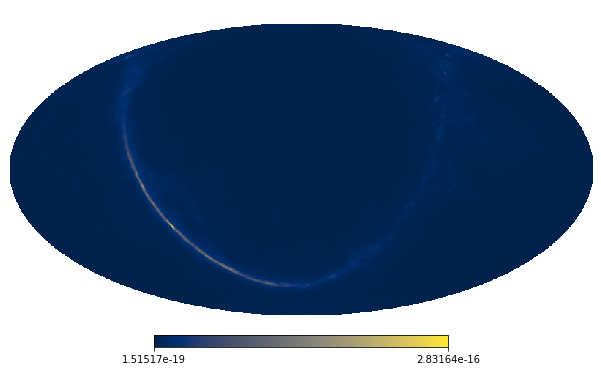

In [8]:
hp.mollview (pi0_flux_per_pixel, rot=(180,0), title=' ')

# Functions

In [9]:
def get_mids(bins, ext=False):
    """ Calculate the bin mids from an array of bins """
    res = (bins[1:] + bins[:-1]) * 0.5
    if ext==False:
        return res
    else:
        res[0], res[-1] = bins[0], bins[-1]
        return res

In [10]:
def energy_smearing(ematrix, ev):
    """Translate a matrix with axis in true energy to reconstructed energy"""
    return (ematrix @ ev.T).T

In [11]:
def atmo_background(aeff_factor, bckg_flux_vals, smear_energy=False):
    """Calculate the number of neutrinos of atmospheric background flux as a function reconstructed energy"""
    if smear_energy:
        return energy_smearing(normed_kvals, aeff_factor * bckg_flux_vals)
    else:
        return aeff_factor_bckg * bckg_flux_per_pixel

In [12]:
def array_source_interp(dec, array):
    """Take a 2D array and interpolate its values
    based on a value (dec) on the second axis"""
    low_ind = np.digitize(np.sin(dec), coszen_bins) - 1

    if low_ind >= (len(coszen_mids)-1):
        array_interp = array[:, -1]
    elif low_ind == 0:
        array_interp = array[:, low_ind]
    else:
        if coszen_mids[low_ind] > np.sin(dec):
            low_ind -= 1
        array_interp = np.zeros(len(array))
        for i in range(len(array)):
            array_interp[i] = np.interp(
                np.sin(dec),
                [coszen_mids[low_ind], coszen_mids[low_ind + 1]],
                [array[i, low_ind], array[i, low_ind + 1]],
            )
    return array_interp


# Get the effective area

In [13]:
#h2d = np.load('/home/ssclafani/data/PONE_nu_effa_70_string.npy', allow_pickle=True)[()]
h2d = np.load('/home/ssclafani/data/pstracks_nu_effa.npy', allow_pickle=True)[()]
h2d

Hist(25 bins in [2.0,7.000000000000004], 49 bins in [-1.0,1.0], with sum 139349.20802387004, 88 empty bins, and 0 non-finite values)

In [14]:
logE_bins = h2d.bins[0]
coszen_bins = h2d.bins[1]
aeff_2d = 1e4*h2d.values #values are in m^2 not cm^2 ?? is this necessary?

In [15]:
# use only upgoing data to mimick up-going muon track data set
#with open("../resources/tabulated_logE_sindec_aeff_full.pckl", "rb") as f:
#    logE_bins, sindec_bins, aeff_2d = pickle.load(f)
#h2d = np.load('/home/steve/pone/data/PONE_nu_effa_70_string.npy')
#logE_bins = h2d.bins

logE_mids = get_mids(logE_bins)
# cut at E=10⁹GeV
logE_bins = logE_bins
aeff_2d = aeff_2d
logE_mids = logE_mids


ebins = np.power(10, logE_bins)
emids = get_mids(ebins)
ewidth = np.diff(ebins)

coszen_mids = get_mids(coszen_bins)
coszen_width = np.diff(coszen_bins)

print(len(emids), "log_10(energy) bins")
print(len(coszen_mids), "declination bins")


25 log_10(energy) bins
49 declination bins


(2.0, 7.0)

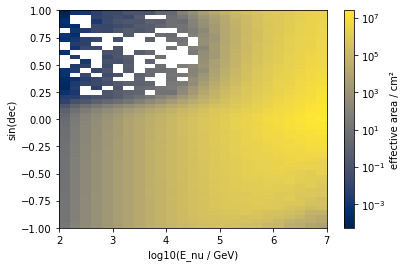

In [16]:
plt.pcolormesh(logE_bins, coszen_bins, aeff_2d.T, norm=LogNorm())
cb = plt.colorbar()
cb.set_label("effective area / cm²")
plt.ylabel("sin(dec)")
plt.xlabel("log10(E_nu / GeV)")
plt.xlim(2, 7)

# Background

In [17]:
mceq = np.load('/home/ssclafani/data/MCEq_flux.pckl', allow_pickle=True)

In [18]:
# MCEQ
with open("/home/ssclafani/data/MCEq_flux.pckl", "rb") as f:
    (e_grid, zen), flux_def = pickle.load(f)
# re-bin the atmospheric background flux
rgi = RegularGridInterpolator(
    (e_grid, -np.cos(np.deg2rad(zen))), np.log(flux_def["numu_total"] + flux_def["mu_total"])
)
# baseline evaluation
ss, em = np.meshgrid(coszen_mids, emids)
bckg_flux_vals = np.exp(rgi((em, ss))).T

(2.0, 7.0)

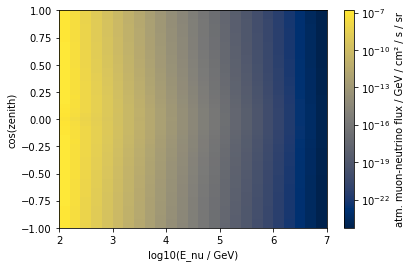

In [19]:
plt.pcolormesh(logE_bins, coszen_bins, bckg_flux_vals, norm=LogNorm())
cb = plt.colorbar()
cb.set_label("atm. muon-neutrino flux / GeV / cm² / s / sr")
plt.ylabel("cos(zenith)")
plt.xlabel("log10(E_nu / GeV)")
plt.xlim(2, 7)

In [52]:
bckg_flux_vals.shape

(49, 25)

# Energy smearing

In [21]:
#Using based energy smearing paramaterization??

In [22]:
'''# energy smearing matrix
with open("/home/steve/pone/Plenum/resources/energy_smearing_rgi.pckl", "rb") as f:
    rgi = pickle.load(f)
# new binning
logE_reco_bins = np.arange(1.9, 7.02, step=0.05)
logE_reco_mids = get_mids(logE_reco_bins)
lge_grid, lre_grid = np.meshgrid(logE_mids, logE_reco_mids)
# baseline evaluation
normed_kvals = rgi((lre_grid, lge_grid))

# normalize per bin in true energy
normed_kvals = normed_kvals / np.sum(normed_kvals, axis=0)'''

'# energy smearing matrix\nwith open("/home/steve/pone/Plenum/resources/energy_smearing_rgi.pckl", "rb") as f:\n    rgi = pickle.load(f)\n# new binning\nlogE_reco_bins = np.arange(1.9, 7.02, step=0.05)\nlogE_reco_mids = get_mids(logE_reco_bins)\nlge_grid, lre_grid = np.meshgrid(logE_mids, logE_reco_mids)\n# baseline evaluation\nnormed_kvals = rgi((lre_grid, lge_grid))\n\n# normalize per bin in true energy\nnormed_kvals = normed_kvals / np.sum(normed_kvals, axis=0)'

In [23]:
'''# logE_mids are the same as for effective area binning
egrid_true, egrid_reco = np.meshgrid(logE_mids, logE_reco_mids)

f, axes = plt.subplots()

axes.grid(False)
im = axes.pcolormesh(egrid_true, egrid_reco, normed_kvals)
axes.set_ylim(np.min(egrid_reco), np.max(egrid_reco))
axes.set_xlim(np.min(egrid_true), np.max(egrid_true))
axes.set_title("Original energy resolution")
axes.set_ylabel(r"$\log_{10}$ ($E_{\rm reco}$ / GeV) (muon energy)")
axes.set_xlabel(r"$\log_{10}$ ($E_{\rm true}$ / GeV) (neutrino energy)")
cb = f.colorbar(im)
cb.set_label("P(E_reco | E_true)")
f.tight_layout()'''

'# logE_mids are the same as for effective area binning\negrid_true, egrid_reco = np.meshgrid(logE_mids, logE_reco_mids)\n\nf, axes = plt.subplots()\n\naxes.grid(False)\nim = axes.pcolormesh(egrid_true, egrid_reco, normed_kvals)\naxes.set_ylim(np.min(egrid_reco), np.max(egrid_reco))\naxes.set_xlim(np.min(egrid_true), np.max(egrid_true))\naxes.set_title("Original energy resolution")\naxes.set_ylabel(r"$\\log_{10}$ ($E_{\rm reco}$ / GeV) (muon energy)")\naxes.set_xlabel(r"$\\log_{10}$ ($E_{\rm true}$ / GeV) (neutrino energy)")\ncb = f.colorbar(im)\ncb.set_label("P(E_reco | E_true)")\nf.tight_layout()'

# Source flux definition

In [24]:
def astro_flux(
    aeff_factor,
    emids,
    E0,
    gamma,
    phi_scaling,
    PHI_0,
    smear_energy=True
):
    """
    flux shape: dphi/dE = phi_0 * (E/E0) ** -gamma
    powerlaw parameters:
        * gamma
        * phi scaling (phi normalization will be phi_0 * phi scaling) 
          -> actual fit parameter will be of magnitude 1 instead of E-14
    """
    if hasattr(PHI_0, "__len__"):
        tmp = np.array([aeff_factor[i] * (emids/E0)**(-gamma) * phi * phi_scaling for i, phi in enumerate(PHI_0)])
    else:
        tmp = aeff_factor * (emids/E0)**(-gamma) * PHI_0 * phi_scaling
    #print(tmp.shape)
    if smear_energy:
        return energy_smearing(normed_kvals, tmp)
    else:
        return tmp

# calculate number of events per source as crosscheck

(should be 39.6 events in total)

In [25]:
'''aeff_factor_signal = (
    array_source_interp(SRC_DEC, aeff_2d) * LIVETIME * ewidth
)
# this is only 1D in energy dimension
k_s = astro_flux(
    aeff_factor_signal,
    emids,
    E0,
    GAMMA,
    1,
    PHI_0=max(pi0_flux_per_pixel),
    smear_energy=False
)
print(np.sum(k_s))
'''

'aeff_factor_signal = (\n    array_source_interp(SRC_DEC, aeff_2d) * LIVETIME * ewidth\n)\n# this is only 1D in energy dimension\nk_s = astro_flux(\n    aeff_factor_signal,\n    emids,\n    E0,\n    GAMMA,\n    1,\n    PHI_0=max(pi0_flux_per_pixel),\n    smear_energy=False\n)\nprint(np.sum(k_s))\n'

In [26]:
effa_template = np.ndarray((hp.nside2npix(128), len(emids)))
bckg_flux_per_pixel = np.ndarray((hp.nside2npix(128), len(emids)))

#reshape effective area in nbins vs energy
for pix, flux in enumerate(pi0_flux_per_pixel):
    theta, phi = hp.pix2ang(nside, pix)
    dec = np.pi/2 - theta
    ra = phi
    sindec = np.sin(dec)
    
    effa_template[pix] = array_source_interp(-dec, aeff_2d)
    bckg_flux_per_pixel[pix] = array_source_interp(-dec, bckg_flux_vals.T)

In [27]:
bckg_flux_per_pixel.shape

(196608, 25)

In [28]:
k_s = []
aeff_factor_signal = (
    effa_template*  LIVETIME * ewidth #* e_psi2_grid
    )    
print(aeff_factor_signal.shape)

k_s = astro_flux(
    aeff_factor_signal, #what to do here?  
    emids,
    E0,
    pi0_spectrum,
    1,
    PHI_0=pi0_flux_per_pixel,
    smear_energy=False,
)
print(k_s.shape)


(196608, 25)
(196608, 25)


In [29]:
k_s.sum()

860.5651594465561

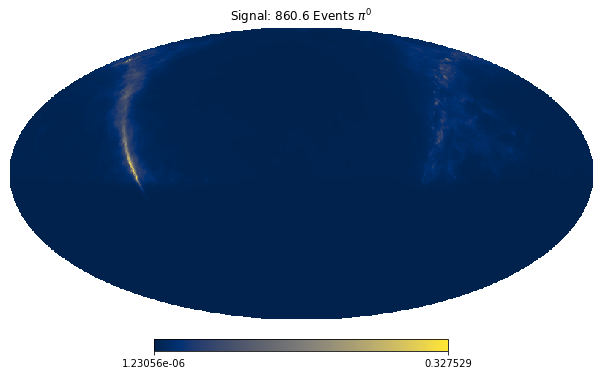

In [30]:
hp.mollview(np.sum(k_s, axis=1), rot=(180,0), title='Signal: {:.1f} Events $\pi^0$'.format(k_s.sum()))

In [31]:
### bkg_b

In [33]:
aeff_factor_bckg = (
        effa_template
        * LIVETIME
        * ewidth
        * hp.nside2pixarea(128, degrees=False) # solid angle approx. 2x?
    )#* bckg_grid * 1
print(aeff_factor_bckg.shape)
k_b = atmo_background(aeff_factor_bckg , bckg_flux_per_pixel, smear_energy=False)
#k_b = atmo_background(aeff_factor_bckg, array_source_interp(dec, bckg_flux_vals.T).T)

(196608, 25)


In [34]:
k_b.shape

(196608, 25)

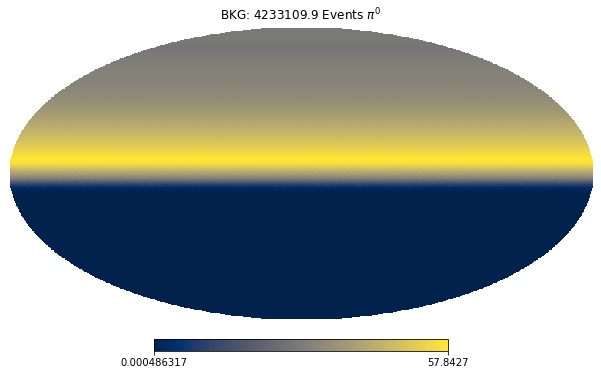

In [35]:
hp.mollview(np.sum(k_b, axis=1), rot=(180,0), title='BKG: {:.1f} Events $\pi^0$'.format(k_b.sum()))

In [36]:
k_b.sum()

4233109.93638391

In [37]:
mu_b_base = deepcopy(aeff_factor_bckg)
mu_s_base = deepcopy(aeff_factor_signal)

In [38]:
k_i = k_b + k_s

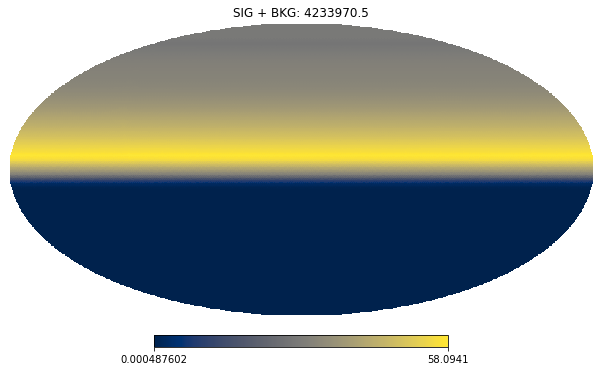

In [39]:
hp.mollview(np.sum(k_i, axis=1), rot=(180,0), title='SIG + BKG: {:.1f}'.format(k_i.sum()))

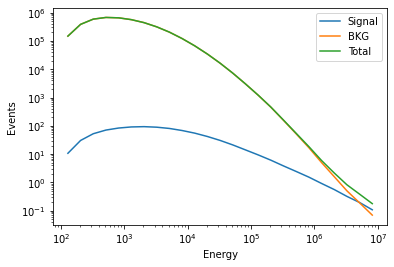

In [40]:
plt.plot(emids, np.sum(k_s, axis=0), label='Signal')
plt.plot(emids, np.sum(k_b, axis=0), label='BKG')
plt.plot(emids, np.sum(k_i, axis=0), label='Total')

plt.loglog()
#plt.title('Signal Events')
plt.xlabel('Energy')
plt.ylabel('Events')
plt.legend()

In [41]:
mu_b_base.shape
mu_s_base.shape
bckg_flux_per_pixel.shape

(196608, 25)

In [42]:
def ps_llh_2d_composite(
    x,
    mu_b_base,
    mu_s_base,
    k_i,
    e_0=E0,
):
    """fit parameters in x:
    for the standard power law:
    x[0]: background normalization scaling
    x[1]: signal normalization scaling

    mu_b_base: effective area factor for background
    mu_s_base: effective area factor for signal
    k_i: observation/asimov data
    e_norm: normalization energy, default E0_NGC
    phi_0: normalization flux, default PHI_NGC
    """

    mu_b = atmo_background(
        mu_b_base * x[0], bckg_flux_per_pixel, smear_energy=False
    )

    mu_s = astro_flux(
        mu_s_base, emids, e_0, pi0_spectrum, x[1], PHI_0=pi0_flux_per_pixel, smear_energy=False
    )
    
    mu_i = mu_s + mu_b
    # -2 Log Likelihood (B/S)
    return -2 * np.sum(
        np.where(
            np.logical_and(mu_i > 0, k_i > 0),
            k_i * np.log(mu_i)
            - mu_i
            - 0.5 * np.log(2 * np.pi * k_i)
            + k_i
            - k_i * np.log(k_i),
            0,
        )
    )#, mu_b, mu_s #for testing
    

In [43]:
'''local_llhs=[]
xs = np.linspace(0,100,100)
for x in xs:
    local_llhs.append(ps_llh_2d_composite(
        (x,0), mu_b_base, mu_s_base, k_i
    ))'''

'local_llhs=[]\nxs = np.linspace(0,100,100)\nfor x in xs:\n    local_llhs.append(ps_llh_2d_composite(\n        (x,0), mu_b_base, mu_s_base, k_i\n    ))'

In [44]:
'''plt.plot(xs, local_llhs)'''

'plt.plot(xs, local_llhs)'

In [45]:
# define the fitting functions with all parameters
# background only, 1 free parameter
local_llh = lambda x: ps_llh_2d_composite(
    (x[0], 0), mu_b_base, mu_s_base, k_i
)
# background + signal, 3 free parameters
global_llh = lambda x: ps_llh_2d_composite(
    (x), mu_b_base, mu_s_base, k_i
)
# ... and fit both hypotheses!
out_bckg = fmin_l_bfgs_b(
    local_llh,
    x0=(1.,),
    epsilon=.01,
    approx_grad=True,
    
)
print("Bckg-only normalization:", out_bckg[0])

out_comp = fmin_l_bfgs_b(
    global_llh,
    epsilon=.01,
    x0=(1.,  .05),
    approx_grad=True,
)
print("Signal fit parameters:", out_comp[0])

# calculate p-value and significance with Wilks' and -2- 1 d.o.f
pval = chi2.sf(out_bckg[1] - out_comp[1], 2)

significance = erfinv(1 - pval) * np.sqrt(2)
print("P-VALUE: {:.6f}".format(pval), "SIGNIFICANCE: {:.3f}".format(significance))


Bckg-only normalization: [1.]
Signal fit parameters: [1.         1.02096267]
P-VALUE: 0.013521 SIGNIFICANCE: 2.470
